## Dependencies

In [33]:
%pip install yfinance
%pip install pandas
%pip install json
%pip install datetime
%pip install collections
%pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import pandas as pd
import json
from datetime import datetime, timedelta
import yfinance as yf
from collections import defaultdict, OrderedDict
import requests
import matplotlib.pyplot as plt
import numpy as np

## General needs

### Functions

In [6]:
def get_sp500_components():
    # URL of the Wikipedia page containing S&P 500 components
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    
    try:
        # Read the table from the webpage
        tables = pd.read_html(url)
        # The first table on the page contains the S&P 500 components
        sp500_table = tables[0]
        
        # Rename columns for convenience
        sp500_table.columns = sp500_table.columns.str.strip()
        sp500_table.rename(columns={'Symbol': 'Ticker'}, inplace=True)

        # Replace '.' with '-' in the 'Ticker' column
        sp500_table['Ticker'] = sp500_table['Ticker'].str.replace('.', '-', regex=False)
        
        # Convert the columns to appropriate types
        sp500_table['Date added'] = pd.to_datetime(sp500_table['Date added'], errors='coerce')
        
        # Convert string columns to str (for consistency)
        sp500_table['Security'] = sp500_table['Security'].astype(str)
        sp500_table['GICS Sector'] = sp500_table['GICS Sector'].astype(str)
        sp500_table['GICS Sub-Industry'] = sp500_table['GICS Sub-Industry'].astype(str)
        sp500_table['Headquarters Location'] = sp500_table['Headquarters Location'].astype(str)
        
        # Convert 'Date added' to string format (this solves the serialization issue)
        sp500_table['Date added'] = sp500_table['Date added'].dt.strftime('%Y-%m-%d')
        
        # Save the dataframe as CSV
        sp500_table.to_csv("sp500_components.csv", index=False)  # Save as CSV
        
        # Create a dictionary with the ticker as the key and the row as the value
        sp500_dict = sp500_table.set_index('Ticker').to_dict(orient='index')
        
        # Save the dictionary as a JSON file with a single object where tickers are the keys
        with open("sp500_components.json", 'w') as json_file:
            json.dump(sp500_dict, json_file, indent=4)  # Save as JSON
        
        # Return the dataframe
        return sp500_table
    
    except Exception as e:
        print(f"Error retrieving S&P 500 components: {e}")
        return pd.DataFrame()

def filter_tickers_by_date(json_path, date_threshold, output_path):
    """
    Filtre les tickers dans le fichier JSON dont la 'Date added' est inférieure à la date spécifiée.
    
    :param json_path: Le chemin du fichier JSON contenant les tickers et leurs informations.
    :param date_threshold: La date limite sous forme de chaîne 'YYYY-MM-DD' pour filtrer les tickers.
    :param output_path: Le chemin du fichier où le nouveau JSON filtré sera sauvegardé.
    :return: Aucun, le fichier JSON filtré est sauvegardé à l'emplacement spécifié.
    """
    # Convertir la date seuil en objet datetime
    date_threshold_obj = datetime.strptime(date_threshold, '%Y-%m-%d')

    try:
        # Charger le fichier JSON
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        # Filtrer les tickers dont la 'Date added' est plus récente que la date seuil
        filtered_data = {
            ticker: info for ticker, info in data.items()
            if datetime.strptime(info['Date added'], '%Y-%m-%d') <= date_threshold_obj
        }

        # Sauvegarder le nouveau JSON filtré
        with open(output_path, 'w') as f:
            json.dump(filtered_data, f, indent=4)

        print(f"Le fichier JSON filtré a été sauvegardé dans {output_path}.")
    
    except Exception as e:
        print(f"Erreur lors du traitement du fichier JSON: {e}")

def count_items_in_json(json_path):
    """
    Compte le nombre d'items dans un fichier JSON.
    
    :param json_path: Le chemin du fichier JSON.
    :return: Le nombre d'items dans le fichier JSON.
    """
    try:
        # Charger le fichier JSON
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        # Retourner le nombre d'éléments (tickers) dans le fichier JSON
        return len(data)
    
    except Exception as e:
        print(f"Erreur lors du traitement du fichier JSON: {e}")
        return 0  # Retourne 0 en cas d'erreur

def get_sp500_closing_prices(start_date_str, json_path, output_json_path):
    """
    Récupère les prix de clôture des actions du S&P 500 depuis une date donnée jusqu'à aujourd'hui,
    et les enregistre dans un fichier JSON avec le format où chaque date est une clé, 
    et chaque ticker est une clé avec son prix de clôture en valeur.
    
    :param start_date_str: Date de début sous forme de chaîne, par exemple '2020-05-01'.
    :param json_path: Le chemin du fichier JSON contenant les informations des stocks du S&P 500.
    :param output_json_path: Le chemin du fichier JSON de sortie pour enregistrer les prix de clôture.
    """
    try:
        # Charger les informations des stocks du S&P 500 depuis le fichier JSON
        with open(json_path, 'r') as f:
            sp500_data = json.load(f)
        
        # Convertir la date de début en objet datetime
        start_date_obj = datetime.strptime(start_date_str, "%Y-%m-%d").date()

        # Créer un dictionnaire pour stocker les prix de clôture par date
        closing_prices_by_date = {}

        # Récupérer les prix de clôture pour chaque ticker du S&P 500
        for ticker, info in sp500_data.items():
            # Récupérer l'objet stock depuis Yahoo Finance
            stock = yf.Ticker(ticker)

            # Obtenir les données historiques depuis la date donnée jusqu'à aujourd'hui
            hist_data = stock.history(start=start_date_str)

            # Ajouter les prix de clôture au dictionnaire en fonction des dates
            for date, row in hist_data.iterrows():
                date_str = date.date().strftime("%Y-%m-%d")
                close_price = row['Close']
                
                # Ajouter le prix de clôture pour ce ticker à la date spécifique
                if date_str not in closing_prices_by_date:
                    closing_prices_by_date[date_str] = {}
                
                closing_prices_by_date[date_str][ticker] = close_price

        # Sauvegarder les prix de clôture dans un fichier JSON
        with open(output_json_path, 'w') as outfile:
            json.dump(closing_prices_by_date, outfile, indent=4)
        
        print(f"Les prix de clôture ont été enregistrés dans {output_json_path}")

    except Exception as e:
        print(f"Erreur lors de la récupération des prix de clôture: {e}")

def calculate_index_value(price_json_file, weights_json_file, output_path):
    """
    Calcule la valeur de l'indice basé sur les prix de clôture et les poids des actions.

    Arguments :
        price_json_file (str) : Le chemin vers le fichier JSON contenant les prix de clôture des actions.
        weights_json_file (str) : Le chemin vers le fichier JSON contenant les poids des actions dans l'indice.
    
    Retourne :
        dict : Dictionnaire avec la date comme clé et la valeur de l'indice comme valeur.
    """
    # Charger les données JSON des prix et des poids
    with open(price_json_file, 'r') as f:
        price_json = json.load(f)
    
    with open(weights_json_file, 'r') as f:
        weights_json = json.load(f)
    
    # Créer un dictionnaire pour stocker la valeur de l'indice
    index_value = {}

    # Parcourir les dates communes entre les prix et les poids
    dates = set(price_json.keys()).intersection(weights_json.keys())

    for date in dates:
        # Initialiser la valeur de l'indice pour la date
        index_value_on_date = 0
        
        # Parcourir chaque stock et calculer la contribution à l'indice
        for stock in price_json[date]:
            if stock in weights_json[date]:
                price = price_json[date][stock]
                weight = weights_json[date][stock]
                index_value_on_date += price * weight
        
        # Enregistrer la valeur de l'indice pour cette date
        index_value[date] = index_value_on_date
    
    # Trier les dates et sauvegarder le résultat dans un fichier JSON
    sorted_index_value = OrderedDict(sorted(index_value.items()))

    with open(output_path, 'w') as outfile:
        json.dump(sorted_index_value, outfile, indent=4)
    
    return sorted_index_value

def plot_index_values(index_values, index_name):
    """
    Affiche un graphique des valeurs de l'indice.

    Arguments :
        index_values (dict) : Dictionnaire contenant les dates comme clés et les valeurs de l'indice comme valeurs.
    """
    # Convertir les dates (format 'YYYY-MM-DD') en objets datetime
    dates = [datetime.strptime(date, "%Y-%m-%d") for date in index_values.keys()]
    values = list(index_values.values())

    # Créer le graphique
    plt.figure(figsize=(10, 6))
    plt.plot(dates, values, label="Index Value", color='blue', marker='o')

    # Ajouter des titres et des labels
    plt.title(f"Evolution des valeurs de l'indice {index_name}")
    plt.xlabel("Date")
    plt.ylabel(f"Valeurs de {index_name}")
    plt.xticks(rotation=45)  # Rotation des dates pour éviter l'empilement
    plt.grid(True)
    plt.tight_layout()

    # Afficher le graphique
    plt.legend()
    plt.show()

def compute_cumulative_covariance(tickers, dates, output_file="cumulative_covariances.json"):
    """
    Calcule la matrice de covariance cumulative pour une liste de tickers à plusieurs dates.

    Arguments :
        tickers (list of str) : Liste des tickers des actions.
        dates (list of str) : Liste des dates limites pour récupérer les données (format 'YYYY-MM-DD').
        output_file (str) : Nom du fichier JSON pour stocker les résultats.

    Retourne :
        dict : Un dictionnaire contenant les matrices de covariance cumulatives pour chaque date.
    """
    try:
        # Convertir les dates en objets datetime
        dates = [datetime.strptime(date, "%Y-%m-%d") for date in dates]

        # Télécharger les données pour chaque ticker
        data_frames = []

        for ticker in tickers:
            stock = yf.Ticker(ticker)
            historical = stock.history(period="max")

            if historical.empty:
                raise ValueError(f"Aucune donnée disponible pour {ticker}.")

            # Conserver seulement les rendements journaliers et ajouter au tableau
            data_frames.append(historical[['Close']].rename(columns={'Close': ticker}))

        # Concaténer toutes les DataFrames des tickers en un seul DataFrame
        daily_returns = pd.concat(data_frames, axis=1).dropna().pct_change().dropna()

        # Supprimer les lignes avec des valeurs manquantes
        daily_returns = daily_returns.dropna()

        if daily_returns.empty:
            raise ValueError("Pas assez de données pour calculer la covariance.")

        # S'assurer que l'index est au format datetime sans fuseau horaire
        daily_returns.index = daily_returns.index.tz_localize(None)

        # Dictionnaire pour stocker les résultats
        results = {}

        # Calculer la matrice de covariance cumulative pour chaque date
        for date in dates:
            # Filtrer les données jusqu'à la date donnée
            filtered_returns = daily_returns[daily_returns.index <= date]

            if filtered_returns.empty:
                print(f"Aucune donnée disponible pour calculer la covariance à la date {date}.")
                continue

            # Calculer la matrice cumulative
            cumulative_covariance = filtered_returns.expanding().cov()
            final_covariance = cumulative_covariance.loc[filtered_returns.index[-1]]
            results[date.strftime("%Y-%m-%d")] = final_covariance.to_dict()

        # Sauvegarder les résultats dans un fichier JSON
        with open(output_file, "w") as json_file:
            json.dump(results, json_file, indent=4)

        return results

    except Exception as e:
        print(f"Erreur : {e}")
        return None

def compute_sp500_cumulative_covariance(sp500ComponentsFile, SP500FinanDataFile, output_file="SP500_covariances_cumulative.json"):
    # Récupérer les composants de l'indice S&P 500
    with open(sp500ComponentsFile, 'r') as f:
        sp500_components = json.load(f)
        sp500_components_tickers = list(sp500_components.keys())
    with open(SP500FinanDataFile, 'r') as f:
        sp500_financial_data = json.load(f)
        dates = list(sp500_financial_data.keys())

    results = compute_cumulative_covariance(tickers=sp500_components_tickers, dates=dates, output_file=output_file)

    return results

def calculate_scores(data1, data2):
    """
    Calcule les scores pour chaque stock en fonction de son GICS Sector.
    """
    # Dictionnaire pour stocker les scores pour chaque date et chaque stock
    result = {}

    # Pour chaque date dans le premier fichier JSON
    for date, stocks in data1.items():
        result[date] = {}

        # Regrouper les stocks par secteur GICS
        gics_sector_dict = {}
        for stock, values in stocks.items():
            gics_sector = data2[stock]["GICS Sector"]
            if gics_sector not in gics_sector_dict:
                gics_sector_dict[gics_sector] = []
            gics_sector_dict[gics_sector].append(values)

        # Calculer les scores pour chaque stock
        for stock, values in stocks.items():
            gics_sector = data2[stock]["GICS Sector"]
            
            # Extraire les valeurs à normaliser
            roe = values["ROE"]
            debt_to_equity = values["DebtToEquity"]
            profit_margin = values["ProfitMargin"]
            operating_cash_flow_debt = values["OperatingCashFlowDebt"]
            market_cap = values["MarketCap"]
            dividend_yield = values["DividendYield"]
            market_to_book = values["MarketToBook"]
            adj_close = values["Adj Close"]

            # Calculer mean et std pour chaque métrique dans le secteur GICS
            gics_stocks = gics_sector_dict[gics_sector]
            roe_values = [s["ROE"] for s in gics_stocks]
            debt_to_equity_values = [s["DebtToEquity"] for s in gics_stocks]
            operating_cash_flow_debt_values = [s["OperatingCashFlowDebt"] for s in gics_stocks]
            market_cap_values = [s["MarketCap"] for s in gics_stocks]
            dividend_yield_values = [s["DividendYield"] for s in gics_stocks]
            market_to_book_values = [s["MarketToBook"] for s in gics_stocks]
            profit_margin_values = [s["ProfitMargin"] for s in gics_stocks]
            

            roe_mean, roe_std = np.mean(roe_values), np.std(roe_values)
            debt_to_equity_mean, debt_to_equity_std = np.mean(debt_to_equity_values), np.std(debt_to_equity_values)
            operating_cash_flow_debt_mean, operating_cash_flow_debt_std = np.mean(operating_cash_flow_debt_values), np.std(operating_cash_flow_debt_values)
            market_cap_mean, market_cap_std = np.mean(market_cap_values), np.std(market_cap_values)
            dividend_yield_mean, dividend_yield_std = np.mean(dividend_yield_values), np.std(dividend_yield_values)
            market_to_book_mean, market_to_book_std = np.mean(market_to_book_values), np.std(market_to_book_values)
            profit_margin_mean, profit_margin_std = np.mean(profit_margin_values), np.std(profit_margin_values)
            

            # Calculer les scores
            roe_score = (roe - roe_mean) / roe_std if roe_std != 0 else 0
            debt_to_equity_score = (debt_to_equity - debt_to_equity_mean) / debt_to_equity_std if debt_to_equity_std != 0 else 0
            operating_cash_flow_debt_score = (operating_cash_flow_debt - operating_cash_flow_debt_mean) / operating_cash_flow_debt_std if operating_cash_flow_debt_std != 0 else 0
            market_cap_score = (market_cap - market_cap_mean) / market_cap_std if market_cap_std != 0 else 0
            dividend_yield_score = (dividend_yield - dividend_yield_mean) / dividend_yield_std if dividend_yield_std != 0 else 0
            market_to_book_score = (market_to_book - market_to_book_mean) / market_to_book_std if market_to_book_std != 0 else 0
            profit_margin_score = (profit_margin - profit_margin_mean) / profit_margin_std if profit_margin_std != 0 else 0
            quality_score = np.mean([roe_score, debt_to_equity_score, profit_margin_score, operating_cash_flow_debt_score])

            # Ajouter les scores au résultat
            result[date][stock] = {
                "ROE_score": roe_score,
                "DebtToEquity_score": debt_to_equity_score,
                "OperatingCashFlowDebt_score": operating_cash_flow_debt_score,
                "Quality_score": quality_score,
                "MarketCap_score": market_cap_score,
                "DividendYield_score": dividend_yield_score,
                "MarketToBook_score": market_to_book_score,
                "Adj Close": adj_close  # La valeur d'Adj Close reste inchangée
            }

    return result

def generate_score_file(json_file_1, json_file_2, output_dir):
    """
    Prend deux fichiers JSON et génère un fichier JSON de scores dans le dossier de sortie.
    """
    # Charger les fichiers JSON
    with open(json_file_1, 'r') as f1:
        data1 = json.load(f1)
    
    with open(json_file_2, 'r') as f2:
        data2 = json.load(f2)

    # Calculer les scores
    scores = calculate_scores(data1, data2)

    # Générer le chemin de sortie
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, "scores.json")

    # Sauvegarder le fichier JSON des scores
    with open(output_file, 'w') as outfile:
        json.dump(scores, outfile, indent=4)

    print(f"Fichier de scores généré : {output_file}")



### Scripts

In [28]:
sp500_components = get_sp500_components()
json_path = "sp500_components.json"  
date_threshold = "2019-12-31"  
output_path = "filtered_sp500_components.json"  
filter_tickers_by_date(json_path, date_threshold, output_path)
sp500_components_item_count = count_items_in_json("sp500_components.json")
filtered_sp500_components_item_count = count_items_in_json("filtered_sp500_components.json")
print(f"Les fichiers {json_path} et {output_path} contiennent respectivement {sp500_components_item_count} et {filtered_sp500_components_item_count} items.")
get_sp500_closing_prices(date_threshold, output_path, "SP500_closes_prices.json")

Le fichier JSON filtré a été sauvegardé dans filtered_sp500_components.json.
Les fichiers sp500_components.json et filtered_sp500_components.json contiennent respectivement 503 et 430 items.
Les prix de clôture ont été enregistrés dans SP500_closes_prices.json


In [7]:
compute_sp500_cumulative_covariance("filtered_sp500_components.json", "SP500ComponentsDailyFinanRatios.json", output_file="SP500_covariances_cumulative.json")

Erreur : Unable to allocate 402. MiB for an array with shape (430, 122550) and data type float64


## Quality ETF

### Functions

### Scripts

## LowVol || MinVol ETF

### Functions 

In [ ]:
def compute_daily_volatility(ticker, end_date):
    """
    Calcule la volatilité quotidienne jusqu'à une date donnée, en utilisant l'historique complet.
    
    Arguments :
        ticker (str) : Le ticker de l'action.
        end_date (str) : La date limite pour récupérer les données (format 'YYYY-MM-DD').
    
    Retourne :
        pd.DataFrame : DataFrame contenant les prix de clôture et la volatilité calculée pour chaque jour.
    """
    try:
        # Télécharger les données historiques jusqu'à end_date
        stock = yf.Ticker(ticker)
        
        # Nous spécifions directement la date en format 'YYYY-MM-DD'
        historical = stock.history(period="max", end=end_date)
        
        if historical.empty:
            raise ValueError(f"Aucune donnée disponible pour {ticker} jusqu'à {end_date}.")

        # Calculer les rendements journaliers
        historical['daily_return'] = historical['Close'].pct_change()

        # Calculer la volatilité cumulative pour chaque jour
        historical['volatility'] = historical['daily_return'].expanding().std()

        # Garder uniquement les colonnes nécessaires
        result = historical[['Close', 'volatility']].dropna()  # Exclure les premières lignes avec NaN

        return result

    except Exception as e:
        print(f"Erreur pour {ticker}: {e}")
        return None

def get_volatility_from_json(json_file, end_date):
    """
    Prend un fichier JSON avec des tickers et calcule la volatilité pour chaque ticker jusqu'à une date donnée.
    
    Arguments :
        json_file (str) : Le chemin vers le fichier JSON contenant les tickers.
        end_date (str) : La date limite pour récupérer les données (format 'YYYY-MM-DD').
    
    Retourne :
        dict : Un dictionnaire avec les dates comme clés et les volatilities par ticker comme valeurs.
    """
    # Charger les tickers depuis le fichier JSON
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    tickers = list(data.keys())
    volatility_data = {}

    # Définir la date de début (31 décembre 2019)
    start_date = pd.to_datetime('2019-12-31').normalize()  # Normalisation à une date tz-naive

    # Parcourir tous les tickers et calculer leur volatilité
    for ticker in tickers:
        volatility_df = compute_daily_volatility(ticker, end_date)
        
        if volatility_df is not None:
            for date, volatility in volatility_df['volatility'].items():
                # Si la date est tz-aware, la rendre tz-naive pour la comparaison
                if date.tzinfo is not None:
                    date = date.tz_localize(None)
                
                # Vérifier si la date est après ou égale au 31 décembre 2019
                if date >= start_date:
                    date_str = date.strftime('%Y-%m-%d')
                    if date_str not in volatility_data:
                        volatility_data[date_str] = {}
                    volatility_data[date_str][ticker] = volatility
    
    return volatility_data

def calculate_daily_weights(json_file):
    """
    Calcule les poids journaliers des actions dans un indice basé sur la volatilité inverse.
    
    Arguments :
        json_file (str) : Le chemin vers le fichier JSON contenant les volatilités des actions.
    
    Retourne :
        dict : Dictionnaire contenant les poids de chaque action dans l'indice pour chaque jour.
    """
    # Charger le JSON à partir du fichier
    with open(json_file, 'r') as f:
        volatility_json = json.load(f)
    
    # Convertir le JSON en DataFrame
    volatility_df = pd.DataFrame(volatility_json).T

    # Créer un DataFrame vide pour les poids
    weights_df = pd.DataFrame(index=volatility_df.index, columns=volatility_df.columns)

    # Calcul des poids journaliers
    for date in volatility_df.index:
        inverse_volatility = 1 / volatility_df.loc[date]
        sum_inverse_volatility = inverse_volatility.sum()
        weights_df.loc[date] = inverse_volatility / sum_inverse_volatility

    # Convertir le DataFrame des poids en dictionnaire pour la sortie JSON
    weights_json = weights_df.to_dict(orient='index')
    
    # Sauvegarder le JSON des poids
    with open('SP500_lowVolIndexWeights.json', 'w') as outfile:
        json.dump(weights_json, outfile, indent=4)

    return weights_json




### Scripts

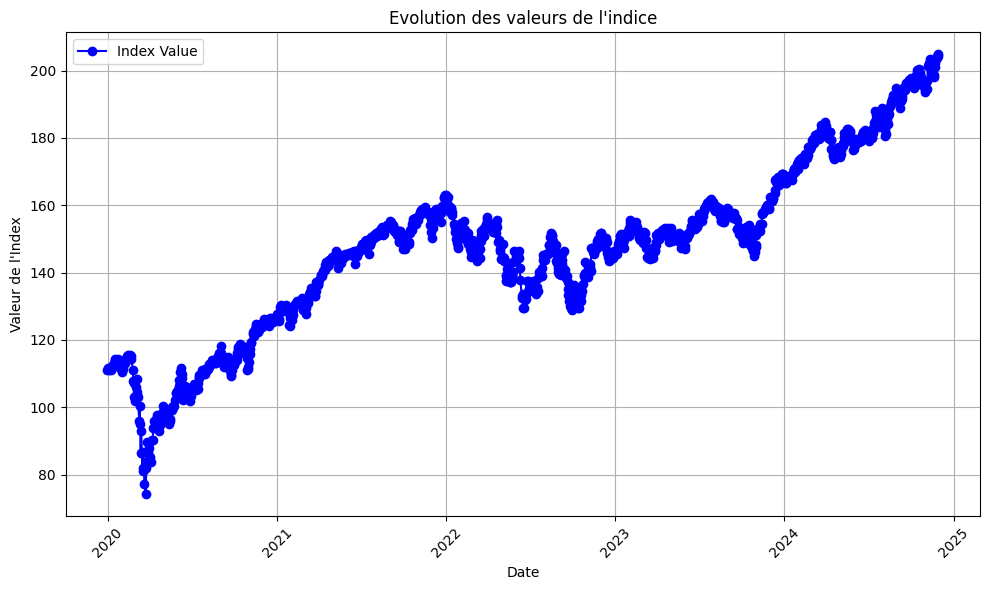

In [ ]:
json_file = "filtered_sp500_components.json"  
end_date = "2024-12-01"
volatility_json = get_volatility_from_json(json_file, end_date)
with open("SP500_histvol.json", "w") as outfile:
    json.dump(volatility_json, outfile, indent=4)

json_file = 'SP500_histvol.json'
weights_json = calculate_daily_weights(json_file)
price_json_file = 'SP500_closes_prices.json'
weights_json_file = 'SP500_lowVolIndexWeights.json'

# Appeler la fonction pour calculer la valeur de l'indice
index_values = calculate_index_value(price_json_file, weights_json_file, "SP500_lowVolIndex_closed_prices.json")
plot_index_values(index_values, "S&P LowVol Index")


## Momentum ETF

### Functions

In [52]:
def calculate_momentum_with_yfinance(input_json_path, output_json_path):
    """
    Calcule le momentum sur une période d'un an pour chaque stock en utilisant Yahoo Finance.
    
    :param input_json_path: Chemin vers le fichier JSON contenant les dates et tickers.
    :param output_json_path: Chemin où sauvegarder le fichier JSON avec les momentum calculés.
    """
    # Charger les données JSON
    with open(input_json_path, 'r') as file:
        price_data = json.load(file)

    # Identifier la plus ancienne date dans les données
    all_dates = [datetime.strptime(date, '%Y-%m-%d') for date in price_data.keys()]
    min_date = min(all_dates)
    start_date = (min_date - timedelta(days=365)).strftime('%Y-%m-%d')

    # Extraire tous les tickers présents dans le fichier
    all_tickers = set()
    for stocks in price_data.values():
        all_tickers.update(stocks.keys())
    tickers = list(all_tickers)

    # Télécharger les données pour tous les tickers
    try:
        data = yf.download(tickers, start=start_date)['Adj Close']
    except Exception as e:
        print(f"Erreur lors du téléchargement des données Yahoo Finance: {e}")
        return

    # Supprimer toute information de fuseau horaire de l'index des données
    data.index = data.index.tz_localize(None)

    # Calculer les momentum pour chaque date et chaque stock
    momentum_data = {}
    for end_date_str, stocks in price_data.items():
        end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
        start_date = end_date - timedelta(days=365)

        if data.empty:
            print(f"Aucune donnée téléchargée pour la période {start_date} à {end_date}.")
            continue

        # Filtrer les données pour la période souhaitée
        filtered_data = data.loc[start_date:end_date]

        # Calculer le momentum pour chaque stock
        momentum_for_date = {}
        for ticker in stocks.keys():
            try:
                if ticker in filtered_data:
                    ticker_data = filtered_data[ticker].dropna()
                    if len(ticker_data) > 1:
                        momentum = ticker_data.iloc[-1] / ticker_data.iloc[0]
                        momentum_for_date[ticker] = momentum
                    else:
                        print(f"Pas assez de données pour {ticker} entre {start_date} et {end_date}")
                else:
                    print(f"Pas de données disponibles pour {ticker}.")
            except Exception as e:
                print(f"Erreur lors du calcul du momentum pour {ticker}: {e}")

        # Ajouter les résultats pour la date actuelle
        momentum_data[end_date_str] = momentum_for_date

    # Sauvegarder les résultats dans un fichier JSON
    with open(output_json_path, 'w') as output_file:
        json.dump(momentum_data, output_file, indent=4)

    print(f"Momentum calculé et sauvegardé dans {output_json_path}")

def calculate_momentum_index_daily_weights(json_file):
    """
    Calcule les poids journaliers des actions dans un indice basé sur leur momentum inverse.
    
    Arguments :
        json_file (str) : Chemin vers le fichier JSON contenant les momentums journaliers des actions.
    
    Retourne :
        dict : Dictionnaire contenant les poids normalisés de chaque action dans l'indice pour chaque jour.
    """
    # Charger le JSON à partir du fichier
    try:
        with open(json_file, 'r') as f:
            momentum_json = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Erreur lors du chargement du fichier JSON : {e}")
        return {}

    # Convertir le JSON en DataFrame
    try:
        momentum_df = pd.DataFrame(momentum_json).T  # Transpose pour avoir les dates en index
        momentum_df = momentum_df.fillna(0)  # Remplacer les valeurs manquantes par 0
    except Exception as e:
        print(f"Erreur lors de la conversion du JSON en DataFrame : {e}")
        return {}

    # Créer un DataFrame vide pour stocker les poids
    weights_df = pd.DataFrame(index=momentum_df.index, columns=momentum_df.columns)

    # Calcul des poids journaliers basés sur le momentum
    for date in momentum_df.index:
        daily_momentum = momentum_df.loc[date]

        # Vérifier si la somme des momentums est valide
        sum_momentum = daily_momentum.sum()
        if sum_momentum > 0:
            # Poids = momentum individuel / somme totale des momentums pour ce jour
            weights_df.loc[date] = daily_momentum / sum_momentum
        else:
            # Si la somme est nulle, attribuer des poids nuls
            weights_df.loc[date] = 0

    # Convertir le DataFrame des poids en dictionnaire pour la sortie JSON
    weights_json = weights_df.to_dict(orient='index')

    # Sauvegarder les poids dans un fichier JSON
    output_file = 'SP500_momentumIndexWeights.json'
    try:
        with open(output_file, 'w') as outfile:
            json.dump(weights_json, outfile, indent=4)
        print(f"Poids journaliers sauvegardés dans {output_file}")
    except Exception as e:
        print(f"Erreur lors de la sauvegarde des poids dans le fichier JSON : {e}")
        return {}

    return weights_json



### Scripts

[*********************100%***********************]  430 of 430 completed
C:\Users\McKing.DESKTOP-4Q7G3QP\AppData\Local\Temp\ipykernel_12328\2091298991.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  momentum = ticker_data[-1] / ticker_data[0]


Momentum calculé et sauvegardé dans momentum.json
Poids journaliers sauvegardés dans SP500_momentumIndexWeights.json


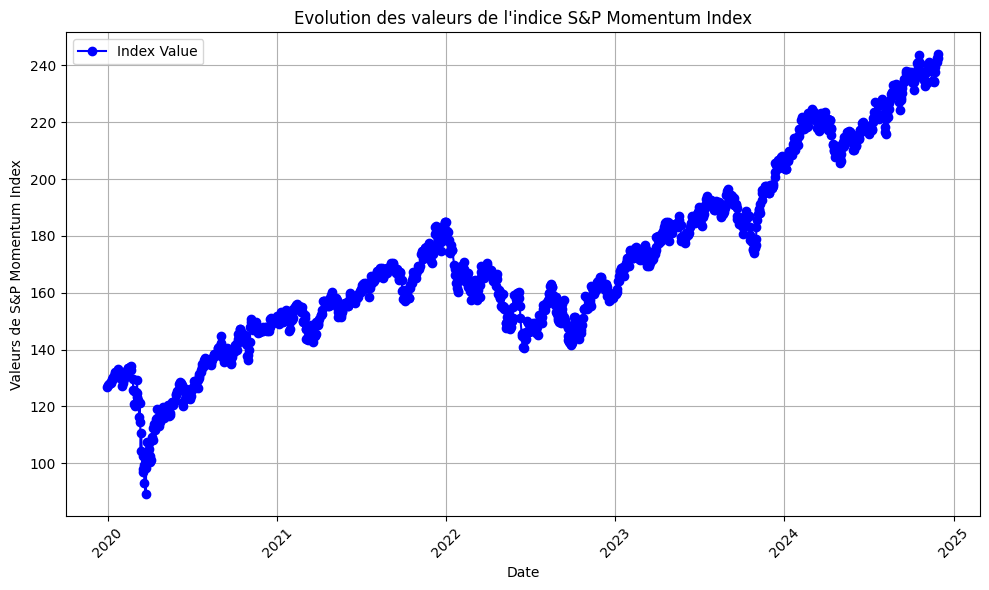

In [51]:
calculate_momentum_with_yfinance("SP500_closes_prices.json", "momentum.json")
calculate_momentum_index_daily_weights("momentum.json")
index_values = calculate_index_value(price_json_file, "SP500_momentumIndexWeights.json", "SP500_momentumIndex_closed_prices.json")
plot_index_values(index_values, "S&P Momentum Index")

##